
**Defining the parts used in unet architecture**
---


In [0]:
# sub-parts of the U-Net model

import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


**Unet Architecture**

In [0]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.sigmoid(x)


**DATASET**


defining dataset, split, data augmentation...

In [0]:
import os

import numpy as np
import torch.utils.data as data
from PIL import Image, ImageOps
from google.colab import drive
drive.mount('/content/gdrive')

root_folder = "/content/gdrive/My Drive/linemod_cat"


class LinemodDataset(data.Dataset):
    def __init__(self, mode, root=root_folder):
        self.root_rgb = root + "/rgb/"
        self.root_label = root + "/mask/"

        self.list_rgb = os.listdir(self.root_rgb)
        self.list_label = os.listdir(self.root_label)
        
        self.list_rgb = sorted(list(set(self.list_rgb) & set(self.list_label)))
        self.list_label = self.list_rgb
        
        self.mode = mode

        # 80 - 20 split
        if mode == "train":
            self.list_rgb = self.list_rgb[0: 1000]
            self.list_label = self.list_label[0: 1000]
            self.length = len(self.list_rgb) * 6

        elif mode == "test":
            self.list_rgb = self.list_rgb[1000: len(self.list_rgb)]
            self.list_label = self.list_label[1000: len(self.list_label)]
            self.length = len(self.list_rgb) 

    def __getitem__(self, index):
        t = 0
        if (self.mode == "train") and (index >= len(self.list_rgb)):
            t = int(index / len(self.list_rgb))
            index = index % len(self.list_rgb)
        img = Image.open(self.root_rgb + self.list_rgb[index])
        label = Image.open(self.root_label + self.list_label[index]).convert('L')# converting to grayscale because of output of network

        # Data augmentation based on t

        if t == 1:
            # h axis
            img = ImageOps.mirror(img)
            label = ImageOps.mirror(label)

        if t == 2:
            # v axis
            img = img.crop((160, 120, 480, 360))
            label = label.crop((160, 120, 480, 360))
            img = ImageOps.mirror(img)
            label = ImageOps.mirror(label)
            img = img.resize((640, 480))
            label = label.resize((640, 480))

        if t == 3:
            # cropping
            img = img.crop((160, 120, 480, 360))
            label = label.crop((160, 120, 480, 360))
            img = img.resize((640, 480))
            label = label.resize((640, 480))

        if t == 4:
            # cropping
            img = img.crop((80,60,560,420))
            label = label.crop((80,60,560,420))
            img = img.resize((640, 480))
            label = label.resize((640, 480))

        if t == 5:
            # cropping
            img = img.crop((80, 60, 560, 420))
            label = label.crop((80, 60, 560, 420))
            img = ImageOps.mirror(img)
            label = ImageOps.mirror(label)
            img = img.resize((640, 480))
            label = label.resize((640, 480))

        img = (np.array(img).astype(np.float32) - 127.5) / 255
        label = np.array(label).astype(np.float32) / 255

        return img.reshape((3, img.shape[0], img.shape[1])), label.reshape((1, label.shape[0], label.shape[1]))

    def __len__(self):
        return self.length

      

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**TRAINING NETWORK**

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

# Loading & Normalize Dataset

trainset = LinemodDataset(mode="train")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

# use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Define NN
net = UNet(n_channels=3, n_classes=1)
net.to(device)

# Define Loss & optimizer
optimizer = optim.SGD(net.parameters(),
                      lr=0.1,
                      momentum=0.9,
                      weight_decay=0.0005)

criterion = nn.BCELoss()
dir_checkpoint = root_folder 

# net.load_state_dict(torch.load(dir_checkpoint+"3CP15.pth"))

# TRAIN NN
for epoch in range(60):  # loop over the dataset multiple times

    running_loss = 0.0
    all_loss = 0.0

    for i, data in enumerate(trainloader, 100):
        # get the inputs
        inputs, labels = data  # inputs [batchsize, h, w, c]; labels [batchsize, h, w]
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        all_loss += loss.item()
        if i % 25 == 0:  # print every 25 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 25))
            running_loss = 0.0

    if True:
        torch.save(
            net.state_dict(),
            dir_checkpoint + 'HD_CP{}.pth'.format(epoch + 1)
        )
        print('Checkpoint {} saved !'.format(epoch + 1))
        print("LOSS FOR THIS EPOCH: ", all_loss  )
        
print('Finished Training')



cuda:0


RuntimeError: ignored

**CHECK  UNET OUTPUT** 

cuda:0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


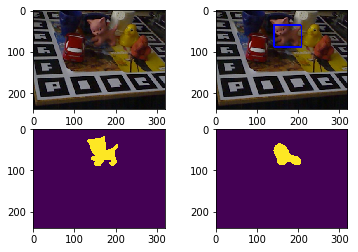

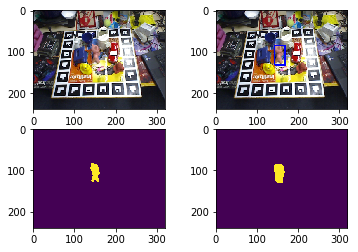

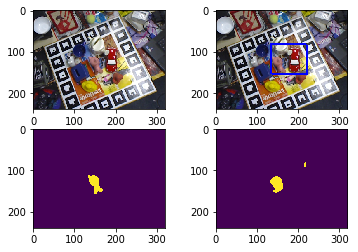

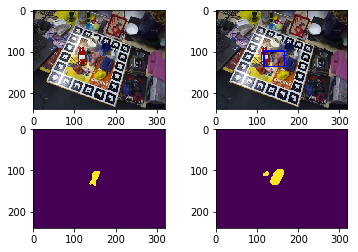

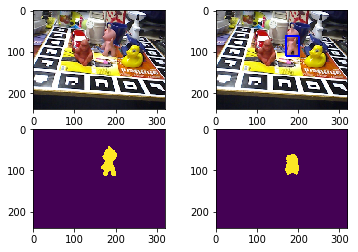

AssertionError: ignored

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt


def drawnRectangle(outputs, inp_seg):
  result = np.where(outputs == 1)
  y0 = np.min(result[0])
  y1 = np.max(result[0])
  x1 = np.max(result[1])
  x0 = np.min(result[1])
  draw = ImageDraw.Draw(inp_seg)
  for i in range(0,4):
    draw.rectangle([(x0 + i,y0 + i),(x1 + i,y1 + i)], outline="blue")
  del(draw)
  return


testset = LinemodDataset(mode="train")
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=1)
dir_checkpoint = root_folder 

# use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Define NN
net = UNet(n_channels=3, n_classes=1)
net.to(device)

# Define Loss & optimizer
optimizer = optim.SGD(net.parameters(),
                      lr=0.1,
                      momentum=0.9,
                      weight_decay=0.0005)

criterion = nn.BCELoss()
net.load_state_dict(torch.load(dir_checkpoint+"4CP10.pth"))


for i, data in enumerate(testloader, 0):
  if i < 5:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)

    outputs = outputs.cpu().detach().numpy()[0, 0, :, :] > 0.49
    labels = labels.cpu().detach().numpy()[0, 0, :, :]
    inputs = (inputs.cpu().detach().numpy()[0, :, :, :]).reshape((240, 320, 3))

    out = Image.fromarray(np.uint8(outputs * 255))
    lab = Image.fromarray(np.uint8(labels * 255))
    inp = Image.fromarray(np.uint8(inputs * 255 + 127.5))
    
    inp_seg = Image.fromarray(np.uint8(inputs * 255 + 127.5))
    drawnRectangle(outputs, inp_seg)
    
    plt.figure(1)
    plt.subplot(221)
    plt.imshow(inp)
    plt.subplot(223)
    plt.imshow(lab)
    plt.subplot(224)
    plt.imshow(out)
    plt.subplot(222)
    plt.imshow(inp_seg)
    plt.show()
   
   
  else:
    assert(False)

**EVALUATION ON TEST SET**

An metric to evaluate a semantic segmentation is to simply report the percent of pixels in the image which were correctly classified. The pixel accuracy is commonly reported for each class separately as well as globally across all classes.

accuracy= (TP+TN) / (TP+TN+FP+FN)

In [ ]:
#EVALUTION

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt


testset = LinemodDataset(mode="test")
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=1)
dir_checkpoint = root_folder 

# use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Define NN
net = UNet(n_channels=3, n_classes=1)
net.to(device)

net.load_state_dict(torch.load(dir_checkpoint+"4CP10.pth"))

tot_accuracy = 0

for i, data in enumerate(testloader, 0):
  inputs, labels = data
  inputs, labels = inputs.to(device), labels.to(device)
  outputs = net(inputs)

  outputs = outputs.cpu().detach().numpy()[0, 0, :, :] > 0.50
  labels = labels.cpu().detach().numpy()[0, 0, :, :]
    
  diff = -((outputs == labels) -1 )
  #n_wrongly_class_px = torch.sum(diff) # gives back a scalar
  n_wrongly_class_px = diff.sum() # fp + fn
  n_correctly_class_px = (diff.shape[0] * diff.shape[1]) - n_wrongly_class_px
    
  accuracy = n_correctly_class_px / (n_correctly_class_px + n_wrongly_class_px)
  
  tot_accuracy = tot_accuracy + accuracy
  
print("Accuracy over test set: ", tot_accuracy / i)


cuda:0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy over test set:  0.9979737242509361
